#### **Implement LLaMa from scratch**
> Based on this [blog post](https://blog.briankitano.com/llama-from-scratch)

In [5]:
import time

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F

**Load the dataset**
> [TinyShakespeare](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt)

In [6]:
dataset_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
file_url = '/content/dataset.txt' # Download and place your file in colab

lines = open(file_url, 'r').read()

vocab = sorted(list(set(lines)))
i2s = { i: ch for i, ch in enumerate(vocab) }
s2i = { ch: i for i, ch in enumerate(vocab) }

print(lines[:50])

First Citizen:
Before we proceed any further, hear


In LLaMa, they use [SentencePiece](https://github.com/google/sentencepiece) byte-pair tokenizer, a simple tokenizer 👇

In [7]:
def encode(s):
  return [ s2i[ch] for ch in s ]

In [8]:
def decode(l):
  return ''.join([ i2s[i] for i in l ])

In [9]:
print(f'vocab size: {len(vocab)}')

vocab size: 65


In [10]:
encode('hello')

[46, 43, 50, 50, 53]

In [11]:
decode([46, 43, 50, 50, 53])

'hello'

**A `config` object to remove magic numbers and store constants, model params**

In [12]:
MASTER_CONFIG = {
    'vocab_size': len(vocab)
}

In [13]:
dataset = torch.tensor(encode(lines), dtype = torch.int8)
dataset.shape

torch.Size([1115393])

**Make a function to generate training data and labels for batches**

In [14]:
def get_batches(data, split, batch_size, context_window, config = MASTER_CONFIG):
  train = data[:int(.8 * len(data))]                      # take first 80% of the data as training set
  val = data[int(.8 * len(data)) : int(.9 * len(data))]   # take the next 10% of data as validation set
  test = data[int(.9 * len(data)):]                       # take the last 10% of data as testing set

  batch_data = train
  if split == 'val':
    batch_data = val
  if split == 'test':
    batch_data = test

  # pick random starting points
  ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
  x = torch.stack([batch_data[i : i + context_window] for i in ix]).long()
  y = torch.stack([batch_data[i + 1 : i + context_window + 1] for i in ix]).long()

  return x, y

In [15]:
MASTER_CONFIG.update({
  'batch_size': 8,
  'context_window': 16
})

In [17]:
xs, ys = get_batches(
  data = dataset,
  split = 'train',
  batch_size = MASTER_CONFIG['batch_size'],
  context_window = MASTER_CONFIG['context_window']
)

[ (decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs)) ]

[('sworn Aumerle;\nA', 'worn Aumerle;\nAn'),
 ('his leave.\n\nKING', 'is leave.\n\nKING '),
 ('oler:\nSo please ', 'ler:\nSo please y'),
 ('tor.\n\nMONTAGUE:\n', 'or.\n\nMONTAGUE:\nB'),
 ('black, and tragi', 'lack, and tragic'),
 ('O just but sever', ' just but severe'),
 ('morrow; to-day; ', 'orrow; to-day; p'),
 (' queen of Englan', 'queen of England')]

**Evaluation**

In [18]:
@torch.no_grad()
def evaluate_loss(model, config = MASTER_CONFIG):
  out = {}
  model.eval()

  for split in ['train', 'val']:
    losses = []

    for _ in range(10):
      xb, yb = get_batches(
        data = dataset,
        split = split,
        batch_size = config['batch_size'],
        context_window = config['context_window']
      )
      _, loss = model(xb, yb)
      losses.append(loss.item())

    out[split] = np.mean(losses)

  model.train()
  return out

#### **Setup a base model**

In the `cross_entropy` loss line, we have to reshape the `logits` and `targets` so that their dimensions match when we compare. \\
We do this using the `view` method, and the `-1` means "infer this dimension from others". \\

So, reshape `logits` and `targets` to have the same number of rows and however many columns that are needed to make that happen.

In [19]:
class SimpleModel(nn.Module):
  def __init__(self, config = MASTER_CONFIG):
    super().__init__()
    self.config = config

    self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
    self.linear = nn.Sequential(
      nn.Linear(config['d_model'], config['d_model']),
      nn.ReLU(),

      nn.Linear(config['d_model'], config['vocab_size'])
    )
    print(f'model params: {sum([m.numel() for m in self.parameters()])}')

  def forward(self, idx, targets = None):
    x = self.embedding(idx)
    a = self.linear(x)
    logits = F.softmax(a, dim = -1)

    if targets is not None:
      loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
      return logits, loss
    else:
      return logits

In [20]:
MASTER_CONFIG.update({
  'd_model': 128
})

In [21]:
model = SimpleModel(MASTER_CONFIG)
xs, ys = get_batches(
  data = dataset,
  split = 'train',
  batch_size = MASTER_CONFIG['batch_size'],
  context_window = MASTER_CONFIG['context_window']
)

logits, loss = model(xs, ys)

model params: 33217


**Train the model**

In [22]:
MASTER_CONFIG.update({
  'epochs': 1_000,
  'log_interval': 10,
  'batch_size': 32
})

In [23]:
model = SimpleModel(MASTER_CONFIG)
optimizer = torch.optim.Adam(model.parameters())

model params: 33217


In [24]:
def train(model, optimizer, scheduler = None, config = MASTER_CONFIG, print_logs = False):
  losses = []
  start_time = time.time()

  for epoch in range(config['epochs']):
    optimizer.zero_grad()

    xs, ys = get_batches(
      data = dataset,
      split = 'train',
      batch_size = MASTER_CONFIG['batch_size'],
      context_window = MASTER_CONFIG['context_window']
    )
    logits, loss = model(xs, ys)

    loss.backward()
    optimizer.step()

    if scheduler:
      scheduler.step()

    if epoch % config['log_interval'] == 0:
      batch_time = time.time() - start_time
      x = evaluate_loss(model)
      losses += [x]

      if print_logs:
        print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
      start_time = time.time()

      if scheduler:
        print(f'learning rate: {scheduler.get_lr()}')

  print(f'validation loss: {losses[-1]["val"]}')
  return pd.DataFrame(losses).plot()

validation loss: 3.949760103225708


<Axes: >

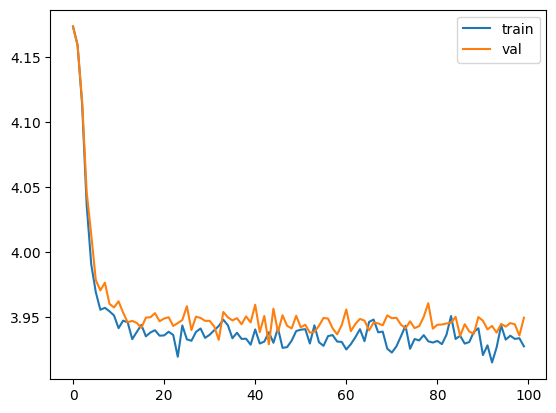

In [25]:
train(model, optimizer)

Continue from [here](https://blog.briankitano.com/llama-from-scratch/#:~:text=Notice%20how%20we%20get%20a%20training%20curve%20that%20goes%20down)